In [1]:
% matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
prices = pd.read_csv('../../data/EuStockMarkets.csv')
prices = prices.rename(columns={'Index': 'Year'}).set_index('Year')

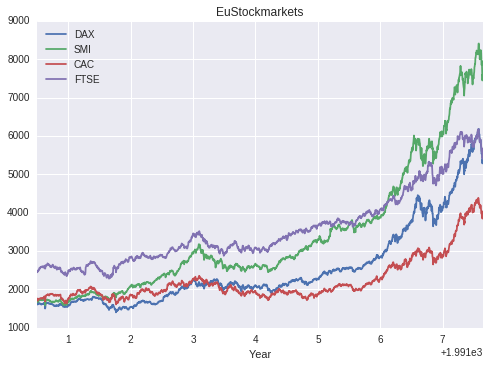

In [3]:
# These are more easily interpreted on one plot, I think
prices.plot(title='EuStockmarkets');
plt.savefig('EuStocks.pdf');

Problem 1) The series is definitely non-stationary, with a clear upward trend for each index. The volatility also seems to increase with time.

In [4]:
logR = np.log(prices).diff().dropna()

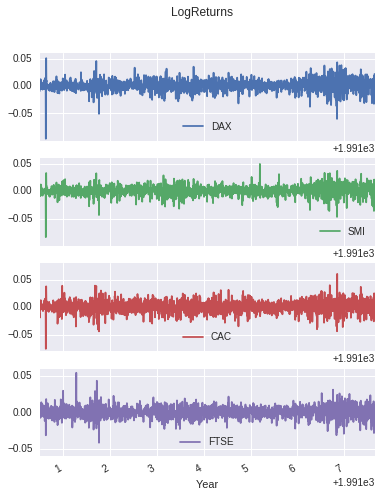

In [5]:
# here we want multiple plots
logR.plot(subplots=True, sharex=True, title="LogReturns", yticks=[-0.05,0,0.05], figsize=(6,8));

Problem 2) These series do look stationary around one. However, the volatility seems to cluster into 'high' and 'low' regimes, with the end of the timeframe experiencing the most voluatility. Also, the regime shifts cooordinate across series.

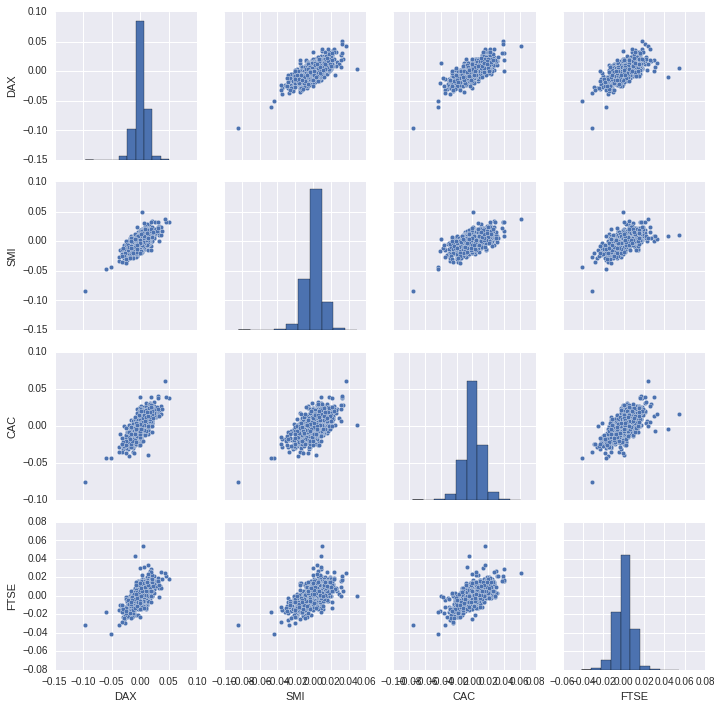

In [6]:
sns.pairplot(logR);

For index DAX, W = 0.9538 and p-value = 0.0000
For index SMI, W = 0.9554 and p-value = 0.0000
For index CAC, W = 0.9820 and p-value = 0.0000
For index FTSE, W = 0.9799 and p-value = 0.0000


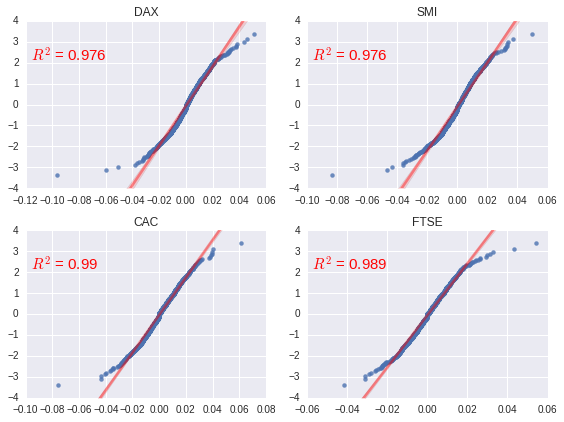

In [7]:
# drawing using seaborns regplot, but without facet-grid
def draw():
    fig = plt.figure(figsize=(8,6))
    for i,name in enumerate(logR.columns):
        ax = plt.subplot(221+i)
        (x,y),(slope,intercept,r) = stats.probplot(logR[name])
        slope, intercept = 1/slope, -intercept/slope
        sns.regplot(y,x, line_kws={'color': 'r', 'alpha': 0.4})
        ax.set_title(name)
        ax.set_ylim(-4,4)
        ax.text(0.02, 0.85, r"$R^2$ = {:.3}".format(r), verticalalignment='top', horizontalalignment='left',
                transform=ax.transAxes, color='red', fontsize=15)
        # print shapiro-wilks statistic and p-value
        W, p = stats.shapiro(logR[name])
        print("For index {}, W = {:.4f} and p-value = {:.4f}".format(name,W,p))
    plt.tight_layout()
draw()

<h3> Problem 3 </h3>
<p> All four plots have much fatter tails than a normal distribution, but are all roughly normal near the 'bulk' of the data. The DAX and the SMI have by far the most left-skew and fattest left tails. The CAC is the closest to being symmetric and has the smallest tails on both sides. The FTSE appears to actually be right-skewed. </p>
<p> The Shapiro-Wilk test for normality definitively states that none of the four series have a normal distribution with all four having *extremely* small p-values </p>

In [8]:
from matplotlib.offsetbox import AnchoredText

n = logR.shape[0]
assert(n == len(logR))
q_grid = np.arange(1,n+1)/(n+1) 
assert(len(q_grid) == n) # R sequences are inclusive on the righ, python is *usually* exclusive
df = [1,4,6,10,20,30]

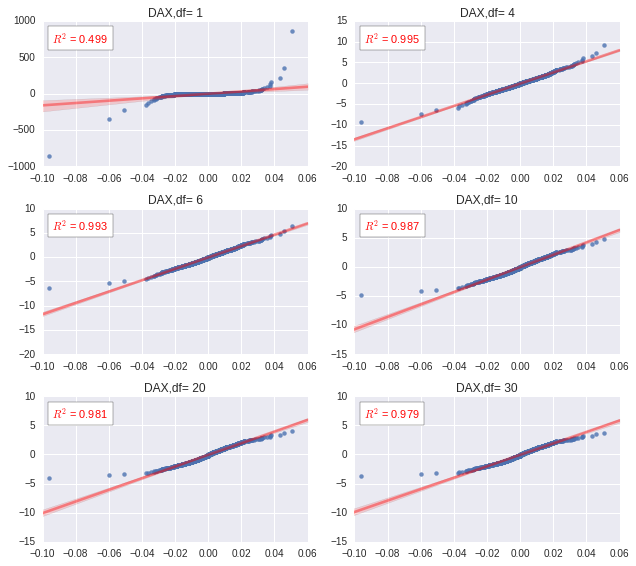

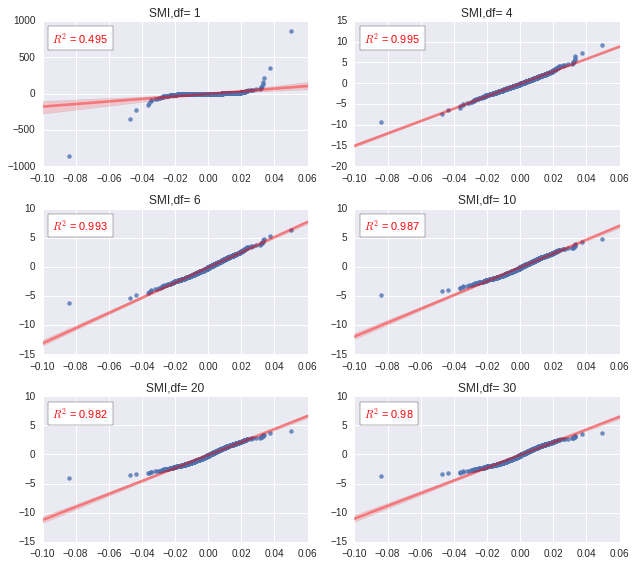

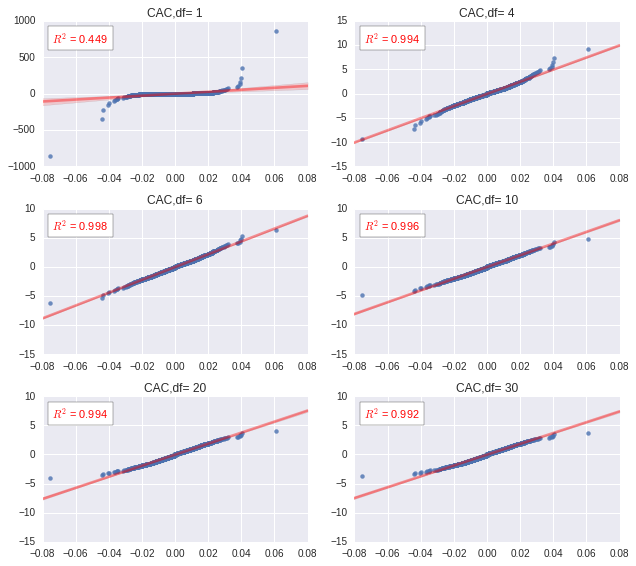

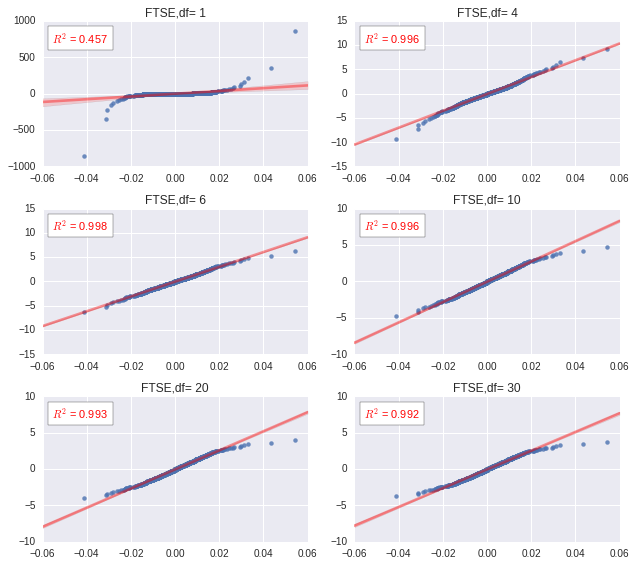

In [9]:
def draw():
    xlims = {'DAX': (-.10,.06),
             'SMI': (-.10,.06),
             'CAC': (-.08,.08),
             'FTSE': (-.06,.06)}
    for name in logR.columns:
        fig = plt.figure(figsize=(9,8))
        for i,degree in enumerate(df):
            ax = plt.subplot(321+i)
            rv = stats.t(degree)
            (x,y),(slope,intercept,r) = stats.probplot(logR[name], dist=rv) 
            sns.regplot(y,x, line_kws={'color': 'r', 'alpha': 0.4})
            ax.set_title("{},df= {}".format(name,degree))
            ax.set_xlim(*xlims[name])
            anchored_text = AnchoredText(r"$R^2$ = {:.3}".format(r), loc=2, prop={'color': 'red', 'fontsize': 11})
            ax.add_artist(anchored_text)
        plt.tight_layout()    
        plt.savefig("t_test_{}.pdf".format(name))
draw()

<h3> Problem 5 </h3>
<p> If we are using $R^2$ as our metric, then for the DAX and the SMI, 4 degrees of freedom gives the best fitting t-distrubtion. For the FTSE and the CAC, 6 degrees of freedom does. This indicates that the DAX and SMI have 'fatter tails' than the FTSE and the CAC which behave relatively more like the normal distribution- which was also observed in the normal probability plots </p>

In [10]:
sortedReturns = sorted(logR['DAX'])
norm_params = (logR['DAX'].mean(), logR['DAX'].std())
t_params = (logR['DAX'].median(), logR['DAX'].mad())

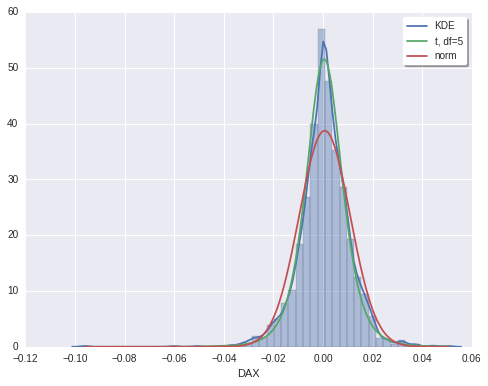

In [11]:
def draw():
    fig = plt.figure(figsize=(8,6))
    sns.distplot(logR['DAX'], kde=True, kde_kws={'kernel': 'gau','bw': 'silverman', 'label':'KDE'});
    plt.plot(sortedReturns,stats.t.pdf(sortedReturns,5,*t_params), label='t, df=5')
    plt.plot(sortedReturns,stats.norm.pdf(sortedReturns,*norm_params), label='norm')
    legend = plt.legend(loc='best', fancybox=True, frameon=True, shadow=True)
    legend.get_frame().set_facecolor('white')
draw()

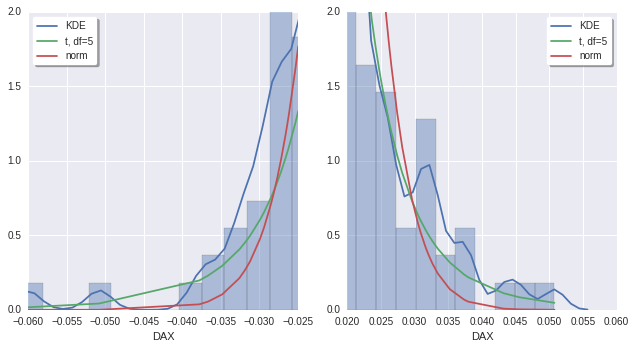

In [12]:
def draw():
    xlims = [(-0.06,-0.025), (0.02,0.06)]
    fig = plt.figure(figsize=(9,5))
    for i, xlim in enumerate(xlims):
        ax = plt.subplot(121+i)
        sns.distplot(logR['DAX'], kde=True, kde_kws={'kernel': 'gau','bw': 'silverman', 'label':'KDE'});
        plt.plot(sortedReturns,stats.t.pdf(sortedReturns,5,*t_params), label='t, df=5')
        plt.plot(sortedReturns,stats.norm.pdf(sortedReturns,*norm_params), label='norm')
        ax.set_ylim(0,2)
        ax.set_xlim(*xlim)
        legend = plt.legend(loc='best', fancybox=True, frameon=True, shadow=True)
        legend.get_frame().set_facecolor('white')
    plt.tight_layout()
draw()

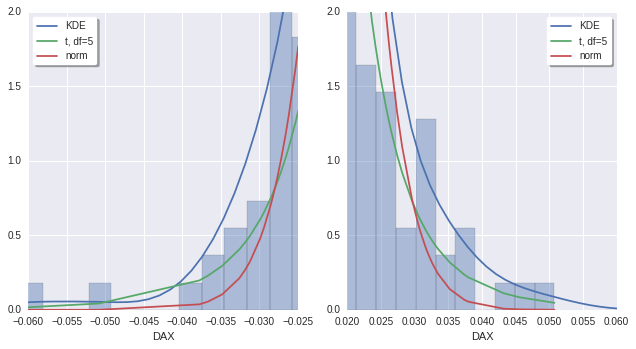

In [13]:
# Using a different bandwith
def draw():
    xlims = [(-0.06,-0.025), (0.02,0.06)]
    fig = plt.figure(figsize=(9,5))
    for i, xlim in enumerate(xlims):
        ax = plt.subplot(121+i)
        sns.distplot(logR['DAX'], kde=True, kde_kws={'kernel': 'gau','bw': 0.005, 'label':'KDE'});
        plt.plot(sortedReturns,stats.t.pdf(sortedReturns,5,*t_params), label='t, df=5')
        plt.plot(sortedReturns,stats.norm.pdf(sortedReturns,*norm_params), label='norm')
        ax.set_ylim(0,2)
        ax.set_xlim(*xlim)
        legend = plt.legend(loc='best', fancybox=True, frameon=True, shadow=True)
        legend.get_frame().set_facecolor('white')
    plt.tight_layout()
draw()

<h3> Problem 6 and 7</h3>
<p> Neighter of the parametric estimates are highly biased and underweight the tails of the distribution, with the normal fit being worse in that regard. In R, the default kernel is guassian and the default estimator is <a href="https://ned.ipac.caltech.edu/level5/March02/Silverman/paper.pdf"> Simpson's 1986 estimator </a>. It appears this estimator chooses too thin a bandwith resulting in a higher bias. The last plot shows a manually selected bandwith that appears to provide a better fit </p>